In [20]:
from __future__ import print_function
import cobra
from matplotlib import pyplot as plt

import os
import pandas as pd
import numpy as np


In [2]:
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 3

In [31]:
model_cons = cobra.io.load_json_model('../resources/glycolysis_ppp_tca_etc_model.json')

## A) Revisiting old assumptions
### 1) Set the objective to ATPM and optimize

In [35]:
model_cons.objective = 'ATPM'
model_cons.optimize()

,fluxes,reduced_costs
NADH2_u10mi,1.000000e+01,3.552714e-15
SUCD1m,2.000000e+00,-4.440892e-15
FADH2ETC,2.000000e+00,7.993606e-15
CYOR_u10mi,1.200000e+01,-8.881784e-15
CYOOm2i,6.000000e+00,-4.440892e-15
...,...,...
SPODM,0.000000e+00,0.000000e+00
GTHPi,0.000000e+00,-4.200000e+00
GTHOr,0.000000e+00,4.440892e-16
EX_r5p_c,0.000000e+00,-4.400000e+01


### 2) Assess the cause of the decrease in ATP yield
Using the glycolysis model and the `pyr_to_ATP` and `NADH_to_ATP` pseudo-reactions, the computed yield was 32 ATP per glucose

Use the `h_i` metabolite's `summary` method to find the reactions producing and consumine the high energy protons

In [36]:
model_cons.metabolites.h_i.summary()

### Modeling alternative pathways

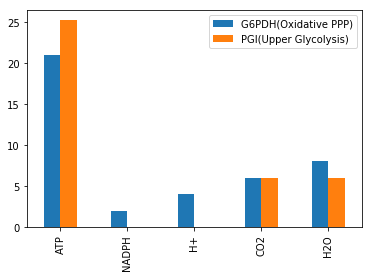

In [29]:
g6pdh = np.linspace(0, 1, 10)
data = []

combined = model_cons.copy()
combined.reactions.EX_glc__D_c.lower_bound = -1
combined.reactions.EX_o2s_c.lower_bound = -1000
combined.objective = 'ATPM_c'


combined.reactions.G6PDH2r.lower_bound = 1
combined.reactions.PGI.upper_bound = 0
combined.reactions.PGI.lower_bound = 0
sol=combined.optimize()
series1 = sol.fluxes[['ATPM_c', 'GTHOr', 'EX_h_c', 'EX_co2_c', 'EX_h2o_c']]
series1.name = 'G6PDH(Oxidative PPP)'

combined.reactions.G6PDH2r.lower_bound = 0
combined.reactions.G6PDH2r.upper_bound = 0
combined.reactions.PGI.lower_bound = 1

sol = combined.optimize()
series2 = sol.fluxes[['ATPM_c', 'GTHOr', 'EX_h_c', 'EX_co2_c', 'EX_h2o_c']]
series2.name = 'PGI(Upper Glycolysis)'

df = pd.DataFrame([series1, series2])
df.columns = ['ATP', 'NADPH', 'H+', 'CO2', 'H2O']
df.abs().T.plot(kind='bar')

### 2) ATP yield as function of superoxide stress

No handles with labels found to put in legend.


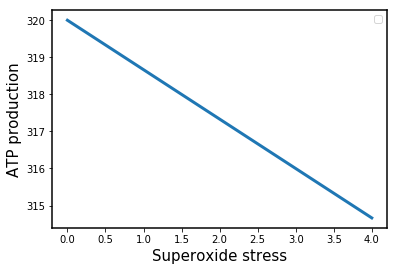

In [14]:
combined = cobra.io.load_json_model('../models/glycolysis_ppp_model.json')
uptake_bounds = np.linspace(0, 4)
atp = []
for b in uptake_bounds:
    combined.reactions.EX_o2s_c.lower_bound = -b
    combined.reactions.EX_o2s_c.upper_bound = -b
    sol = combined.optimize()
    atp.append(sol.x_dict['ATPM'])
plt.plot(uptake_bounds, atp)
plt.legend()
plt.xlabel('Superoxide stress', size=15)
plt.ylabel('ATP production', size=15)
plt.show()

### 2) ATP yield as function of superoxide stress and r5p demand for biosynthesis)

In [1]:
from fba4l.helper_functions.phase_plane import calculate_phenotype_phase_plane
data = calculate_phenotype_phase_plane(combined, 'EX_o2s_c', 'EX_r5p_c', reaction1_range_max=-15, reaction2_range_max=10)
data.plot()

NameError: name 'combined' is not defined

### 3) Introduction to alternative solutions
High ATP yield and low ATP yield solutions

In [3]:
combined = cobra.io.load_json_model('../models/glycolysis_ppp_model.json')
combined.reactions.EX_o2s_c.upper_bound = 0
combined.reactions.EX_o2s_c.lower_bound = -20
combined.reactions.EX_glc__D_c.lower_bound = -1

combined.reactions.EX_r5p_c.lower_bound = 0
combined.reactions.EX_r5p_c.upper_bound = 1000

rxn = 'ATPM'
var_rxn = 'G6PDH2r'
var_rxn_2 = 'PGI'
combined.objective = rxn
obj = combined.optimize().f
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).lower_bound = bound
    combined.reactions.get_by_id(rxn).upper_bound = bound

    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').f)
    upper.append(combined.optimize().f)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').f)
    lower_2.append(combined.optimize().f)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0
plt.fill_between(bounds, upper, lower, label='G6PDH(ppp)', alpha=.7)
plt.fill_between(bounds, upper_2, lower_2, label='PGI(glycolysis)', alpha=.7)
plt.legend()
plt.xlabel(rxn + ' flux')
plt.ylabel('Range of possible fluxes')
plt.savefig(out_loc + 'fva.png')

NameError: name 'cobra' is not defined

### 4) Sampling

In [48]:
combined = cobra.io.load_json_model('../models/glycolysis_ppp_model.json')
combined.reactions.EX_glc__D_c.lower_bound = -1
combined.reactions.EX_glc__D_c.upper_bound = -1
df = cobra.flux_analysis.sample(combined, 5000)

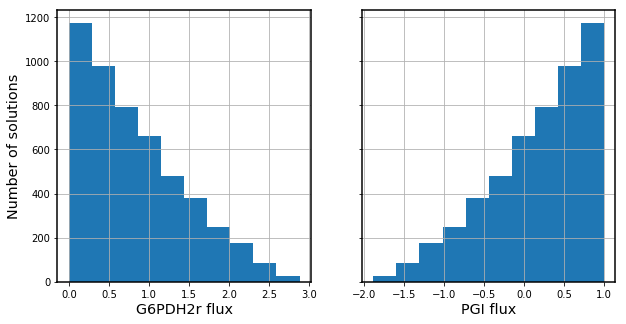

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['G6PDH2r'].hist(ax=ax)
ax.set_xlabel('G6PDH2r flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['PGI'].hist()
ax.set_xlabel('PGI flux')
ax.figure.savefig(out_loc + 'sampling.png')


## Interactive PGI vs G6PDH flux split

In [21]:

init_notebook_mode(connected=True)

g6pdh = np.linspace(0, 1, 11)
data = []

combined = cobra.io.load_json_model('../models/glycolysis_ppp_model.json')
combined.reactions.EX_glc__D_c.lower_bound = -1
combined.objective = 'ATPM'
combined.reactions.pyr_to_ATP.knock_out()
combined.reactions.NADH_to_ATP.knock_out()
r = cobra.Reaction('NADHM')
combined.add_reaction(r)
r.build_reaction_from_string('nadh_c -> nad_c + h_c')
combined.reactions.EX_lac__L_c.upper_bound = 0

steps = []
for q, i in enumerate(g6pdh):
    i = round(i, 1)
    combined.reactions.G6PDH2r.lower_bound = i
    combined.reactions.G6PDH2r.upper_bound = i
    sol = combined.optimize()
    data.append(go.Bar(visible = False,
         name = 'G6PDH = %.2f' % i,
         x = ['ATP', 'NADPH', 'PYR', 'NADH', 'C02', 'H'],
         y = [sol.fluxes['ATPM'], abs(sol.fluxes['GTHOr']), 
              sol.fluxes['EX_pyr_c'], sol.fluxes['NADHM'],
              sol.fluxes['EX_co2_c'], abs(sol.fluxes['EX_h_c'])]))


    step = dict(
        method = 'restyle',  
        label = i,
        args = ['visible', [False] * len(g6pdh)],
    )
    step['args'][1][q] = True # Toggle i'th trace to "visible"
    steps.append(step)

data[0]['visible'] = True

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "G6PDH Flux: "},
    pad = {"t": 50},
    steps = steps
)]

layout = dict(sliders=sliders,
              yaxis=dict(
                      title='Flux',
                titlefont=dict(
                    size=16,
                    color='rgb(107, 107, 107)'
                ),
                tickfont=dict(
                    size=14,
                    color='rgb(107, 107, 107)'
                ),
                range=[0, 8]
            ))

fig = dict(data=data, layout=layout)

iplot(fig)